In [89]:
import numpy as np
import pandas as pd

def load_football():
    df = pd.read_csv('football.csv', delimiter=';')
    
    return df

In [90]:
df = load_football()
names = list(df.columns)

test = df[df["GoalsScored"].isna()]
train = df[~df["GoalsScored"].isna()]

In [91]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X, y = train.drop(columns=["GoalsScored"]), train["GoalsScored"]
X = scaler.fit_transform(X)

# GLMs require intercept
X = np.hstack((np.ones((X.shape[0], 1)), X))    # (n_samples, n_features + 1)
y = y.to_numpy().flatten().astype(int)

In [92]:
train.isna().sum()  # Check for any remaining NaN values in the training set

X_ScoreRateH      0
X_ScoreRateA      0
X_ConcedeRateH    0
X_ConcedeRateA    0
X_CornerRatioH    0
X_CornerRatioA    0
X_FoulRatioH      0
X_FoulRatioA      0
GoalsScored       0
dtype: int64

Poisson GLM: \
p(Beta | y) = p(y | Beta) * p(Beta) \
Poisson = Poisson(Exp) * Normal 

In [93]:
X.shape, type(y), y.shape  # Check the shape of X and type of y

((1750, 9), numpy.ndarray, (1750,))

In [94]:
# https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html
import pymc as pm

# alpha + beta X
alpha = 5
with pm.Model(coords={"predictors": names[:-1]}) as model:
    _X = pm.Data("X", X)  
    _y = pm.Data("y", y)
    
    # Define the prior for alpha
    beta = pm.Normal("beta", mu=0, sigma=alpha, shape=X.shape[1])

    # Define the likelihood
    mu = pm.math.exp(pm.math.dot(_X, beta))   # lambda = exp(X @ beta) = log link
    y_obs = pm.Poisson("y_obs", mu=mu, observed=_y)  # Likelihood
    
    # Get inference data
    idata = pm.sample(1000, tune=1000, return_inferencedata=True, chains=5)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [beta]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 21 seconds.


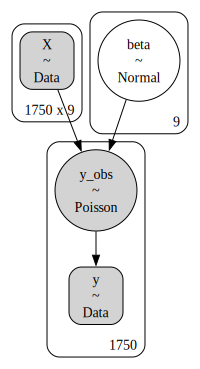

In [95]:
pm.model_to_graphviz(model)

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [97]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

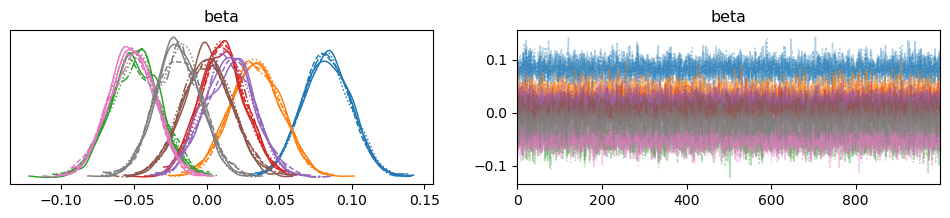

In [98]:
az.plot_trace(idata, coords={"beta_dim_0": list(range(1, 9))}, combined=False, var_names=["beta"])

In [99]:
names

['X_ScoreRateH',
 'X_ScoreRateA',
 'X_ConcedeRateH',
 'X_ConcedeRateA',
 'X_CornerRatioH',
 'X_CornerRatioA',
 'X_FoulRatioH',
 'X_FoulRatioA',
 'GoalsScored']

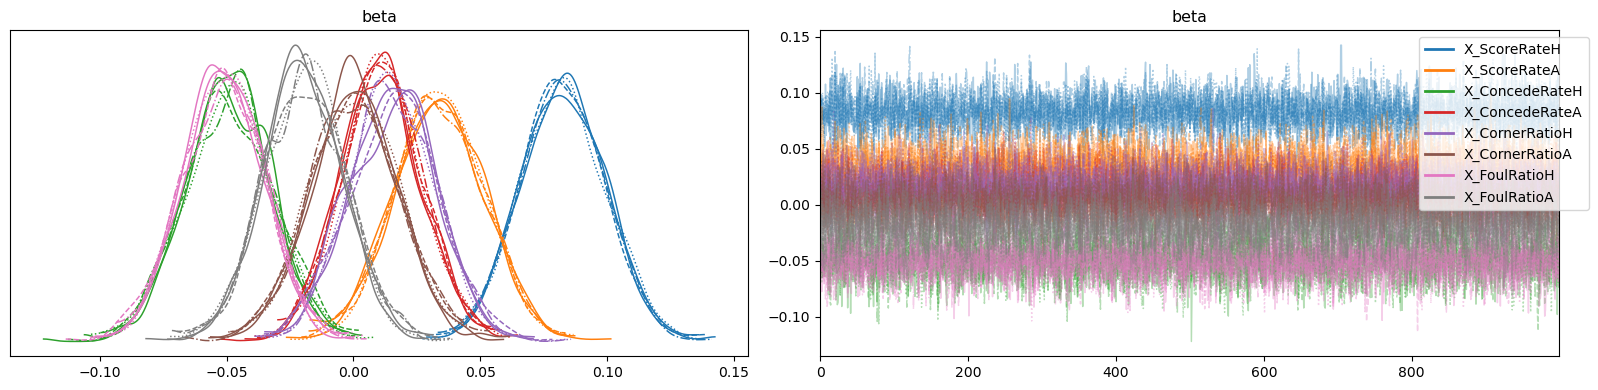

In [100]:
axes = az.plot_trace(idata, coords={"beta_dim_0": list(range(1, 9))}, combined=False, var_names=["beta"], figsize=(16, 4))
chain_colors = [line.get_color() for line in axes[0, 0].lines[::5]]  # Get colors from the first row
num_chains = len(chain_colors)
legend_labels = [f"{names[i]}" for i in range(num_chains)]

# Create custom legend handles
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], color=color, lw=2) for color in chain_colors]

# Add legend to the entire figure
plt.legend(handles, legend_labels, loc='upper right', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

B > 0: feature increases predicted goals

In [101]:
mean_betas = np.mean(idata.posterior.beta.values, axis=(0, 1))  

In [102]:
_test = df[100:500].drop(columns=["GoalsScored"])
_test = scaler.transform(_test) 
_test = np.hstack((np.ones((_test.shape[0], 1)), _test)) 
predictions = np.exp(np.dot(_test, mean_betas))  

In [103]:
# Get MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df["GoalsScored"][100:500], predictions)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 2.88


In [104]:
print(np.mean(predictions == df[100:500]["GoalsScored"].to_numpy().flatten().astype(int)))  # Accuracy of predictions

0.0


In [105]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=123)

Sampling: [y_obs]


Output()

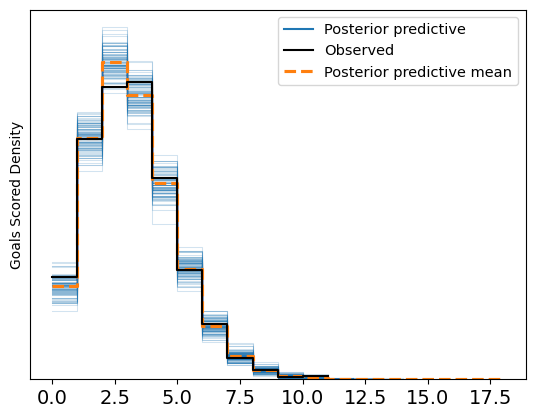

In [170]:
ax = az.plot_ppc(idata, num_pp_samples=100)
ax.set_ylabel("Goals Scored Density")
ax.tick_params(axis='y', which='both', labelleft=True, left=True)

ax.set_ylim(0, None)
ax.set_yticks(ax.get_yticks())  # Force showing ticks
ax.set_xlabel("")
plt.show()

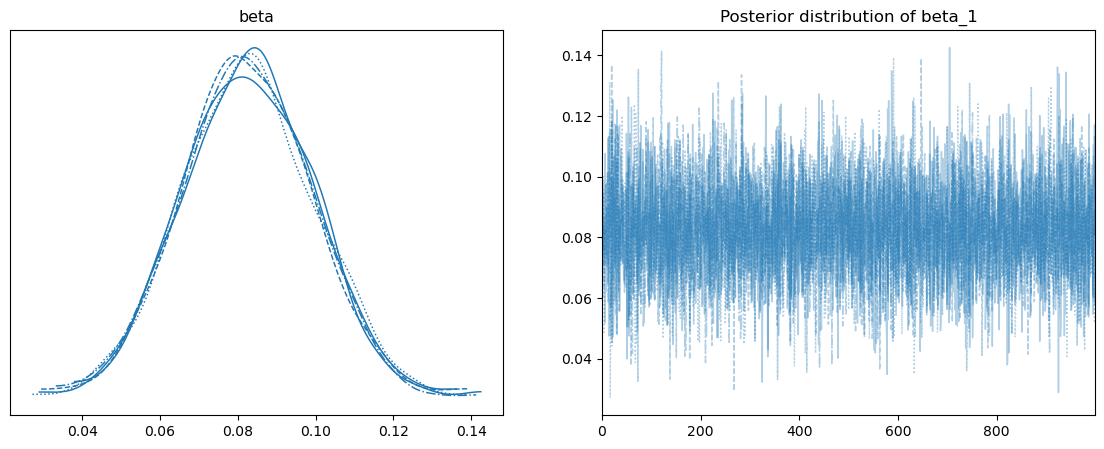

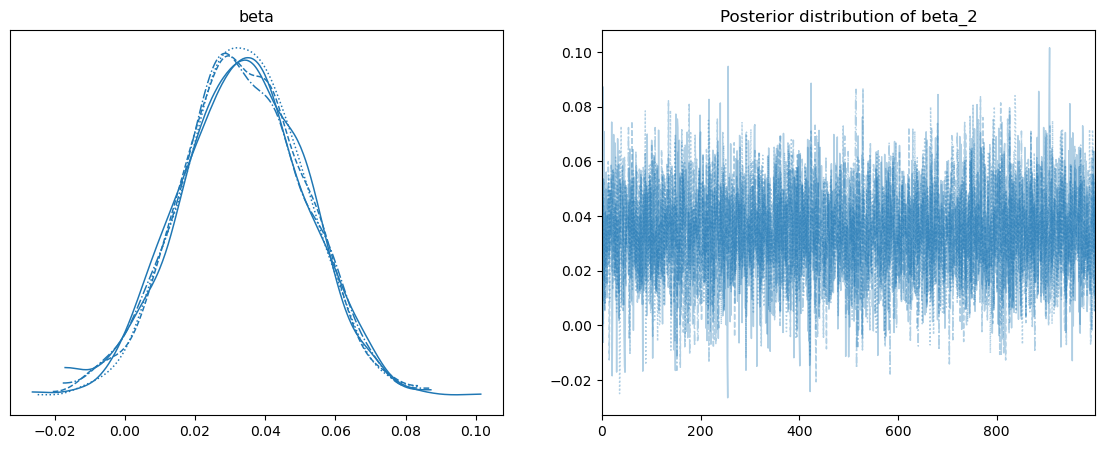

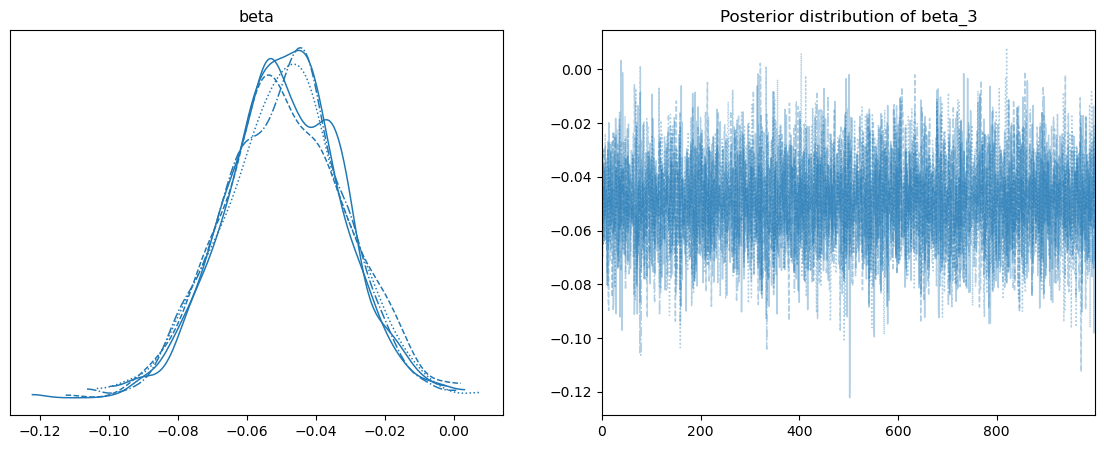

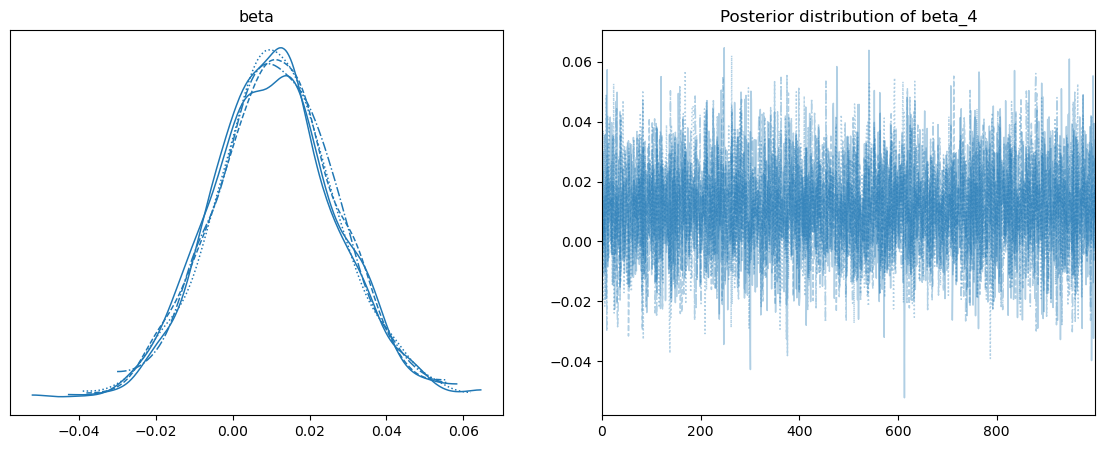

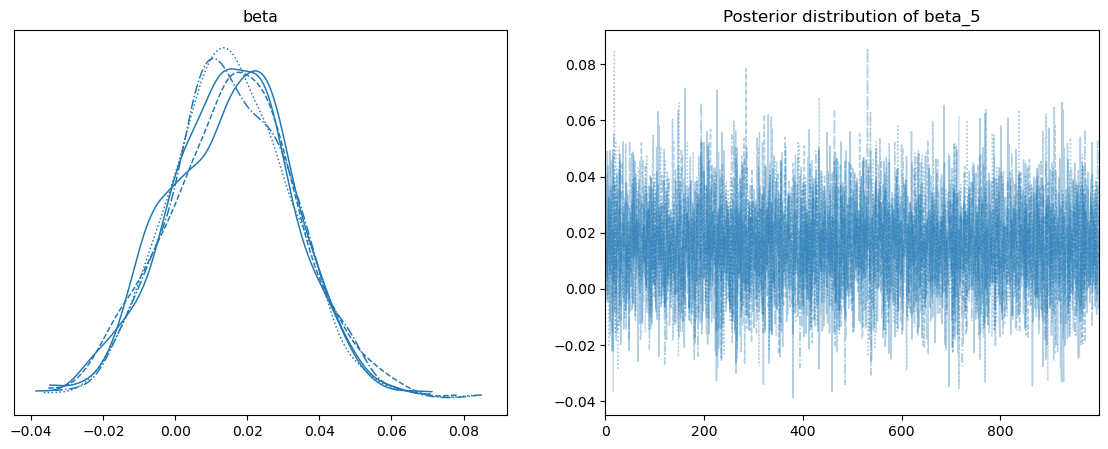

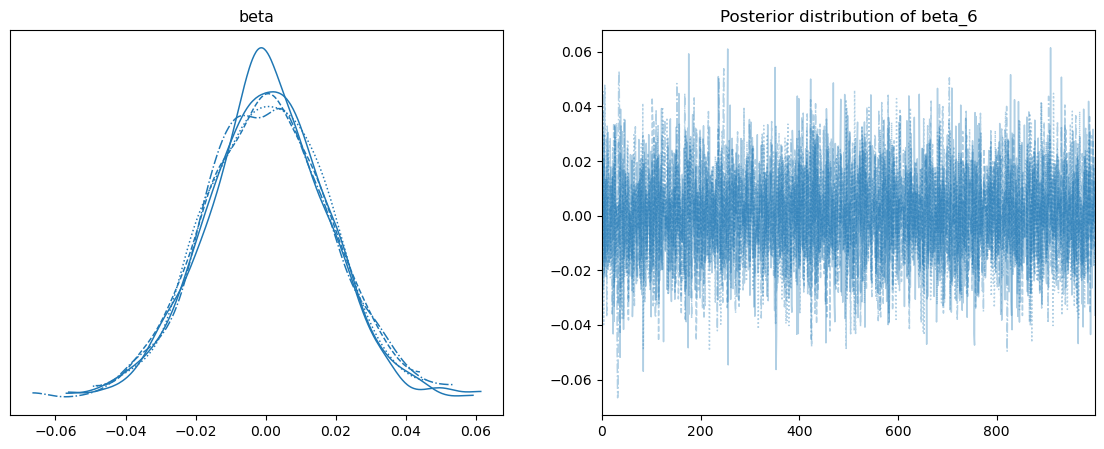

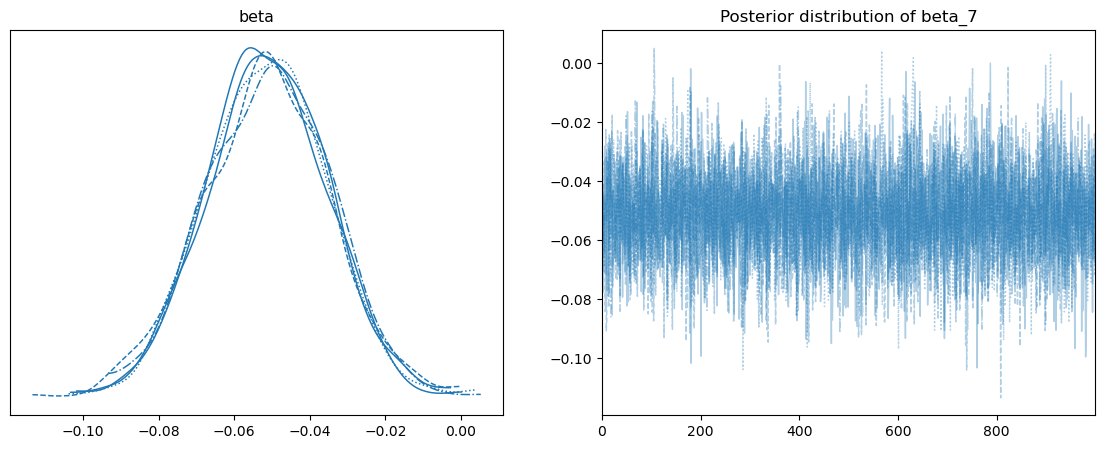

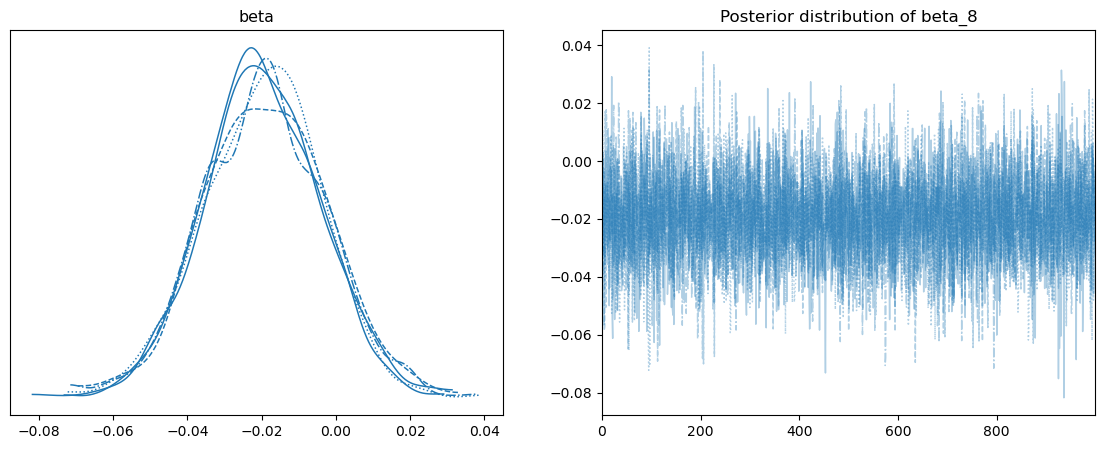

In [107]:
for i in range(1, 9):
    az.plot_trace(idata, coords={"beta_dim_0": i}, var_names=["beta"], figsize=(14, 5), combined=False)
    plt.title(f"Posterior distribution of beta_{i}")
    plt.show()

In [108]:
az.summary(idata)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]  0.999  0.015   0.970    1.026        0.0      0.0    8832.0   
beta[1]  0.083  0.017   0.051    0.113        0.0      0.0    7511.0   
beta[2]  0.034  0.018   0.000    0.066        0.0      0.0    7574.0   
beta[3] -0.049  0.017  -0.081   -0.017        0.0      0.0    8059.0   
beta[4]  0.011  0.016  -0.020    0.040        0.0      0.0    8405.0   
beta[5]  0.016  0.017  -0.017    0.046        0.0      0.0    8127.0   
beta[6]  0.000  0.017  -0.032    0.033        0.0      0.0    7967.0   
beta[7] -0.051  0.016  -0.081   -0.022        0.0      0.0    6711.0   
beta[8] -0.020  0.016  -0.049    0.011        0.0      0.0    7979.0   

         ess_tail  r_hat  
beta[0]    3361.0    1.0  
beta[1]    3715.0    1.0  
beta[2]    3765.0    1.0  
beta[3]    3830.0    1.0  
beta[4]    3665.0    1.0  
beta[5]    3655.0    1.0  
beta[6]    4120.0    1.0  
beta[7]    3782.0    1.0  
beta[8]    3689.0    1.0

In [109]:
az.summary(idata)["ess_bulk"].mean()  # Effective sample size for bulk of the posterior


np.float64(7907.222222222223)

<Axes: >

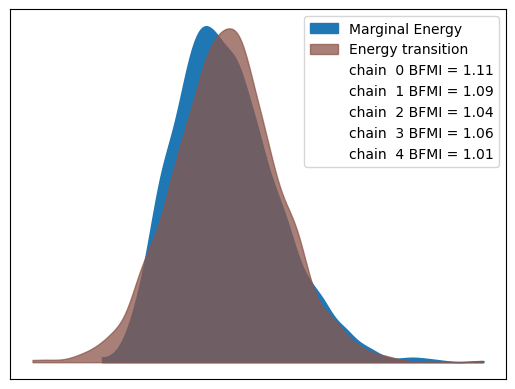

In [110]:
az.plot_energy(idata)

(-0.08, 0.08)

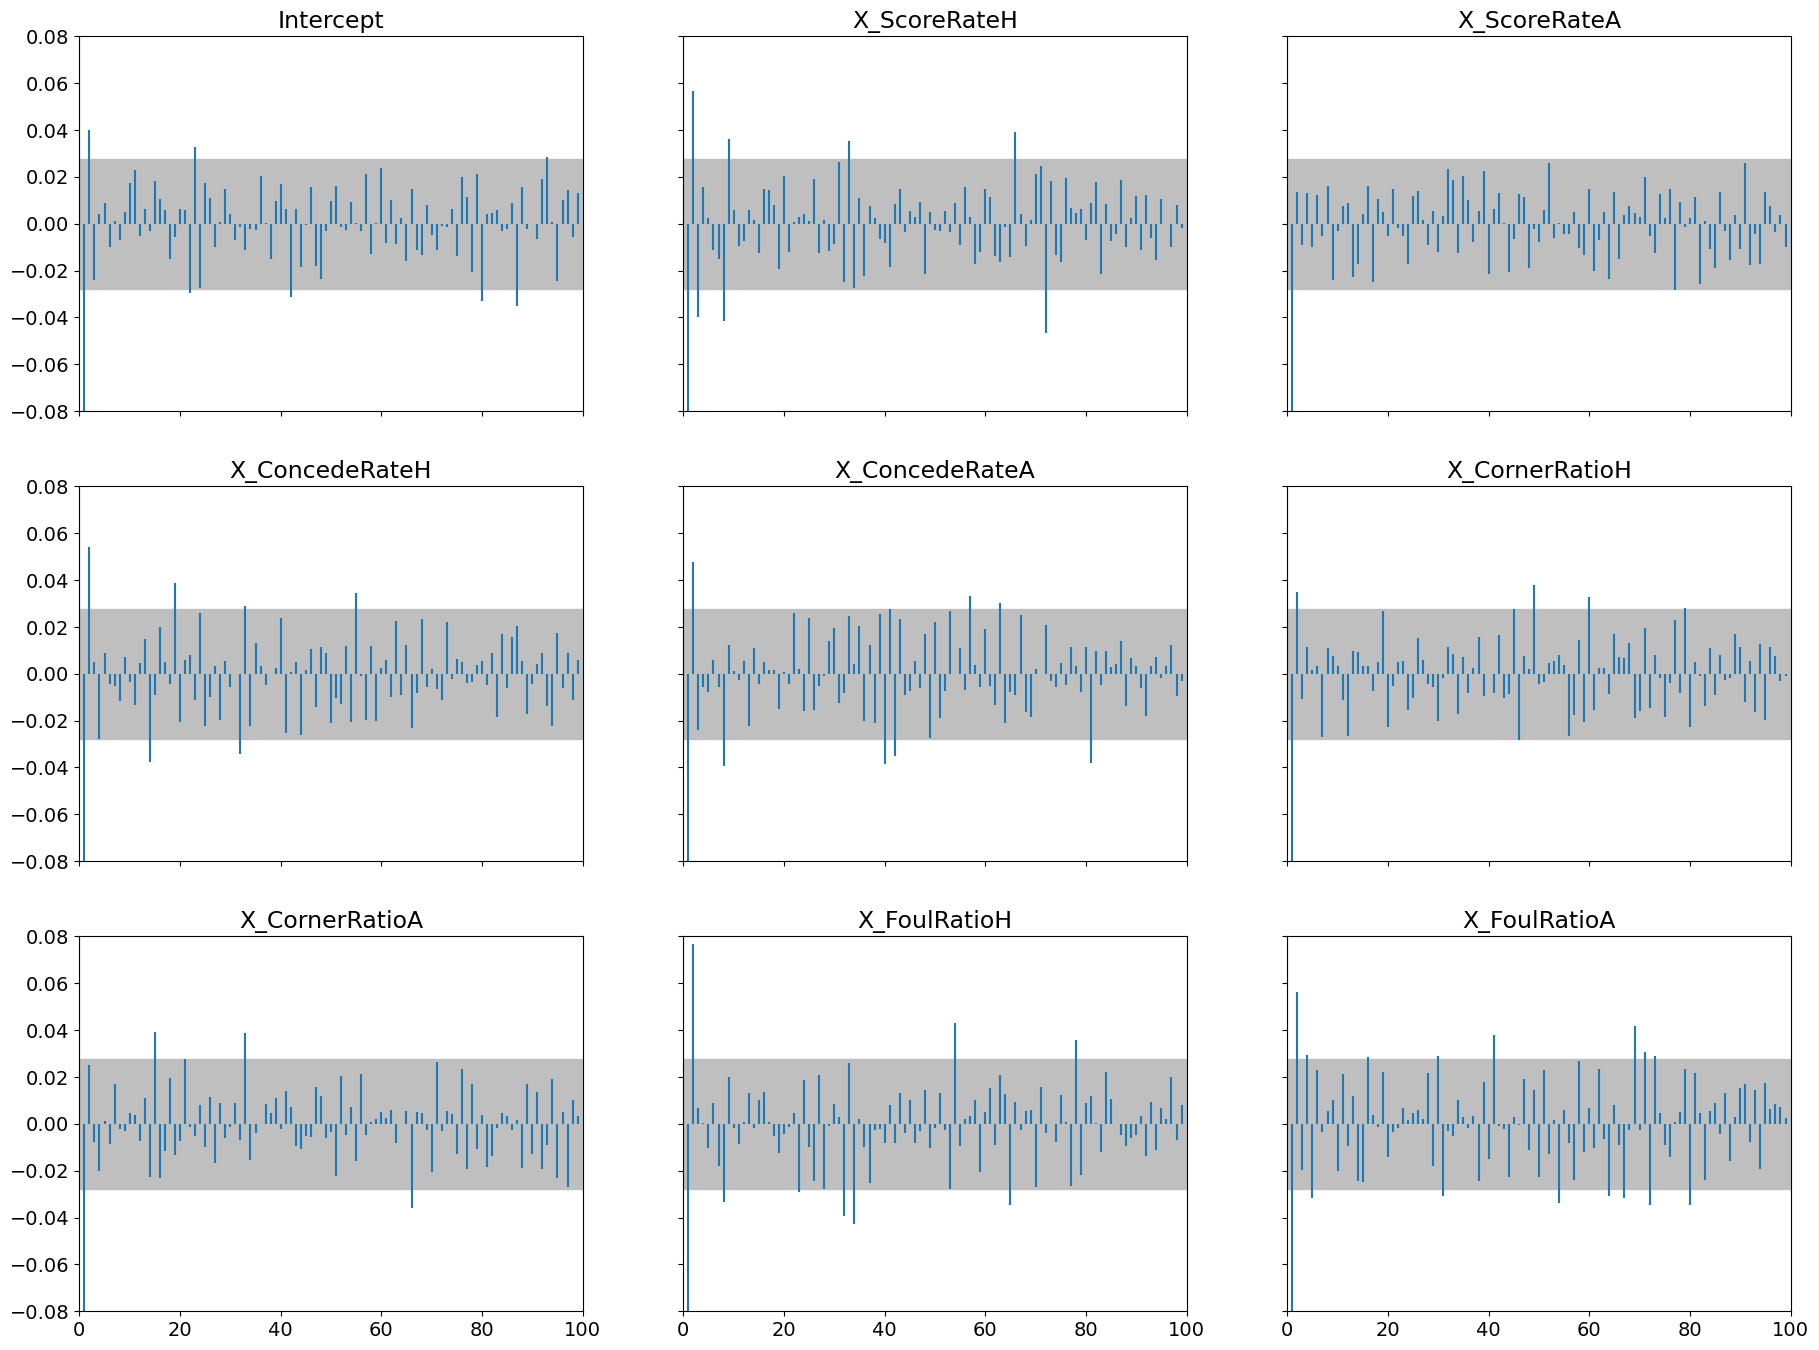

In [111]:
ax = az.plot_autocorr(idata, var_names=["beta"], combined=True)
ax = ax.flatten()
for i in range(9):
    ax[i].set_title(names[i-1], fontsize=17)
    if i == 0:
        ax[i].set_title("Intercept", fontsize=17)
plt.ylim(-0.08, 0.08)

array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n5'}>],
       [<Axes: title={'center': 'beta\n6'}>,
        <Axes: title={'center': 'beta\n7'}>,
        <Axes: title={'center': 'beta\n8'}>]], dtype=object)

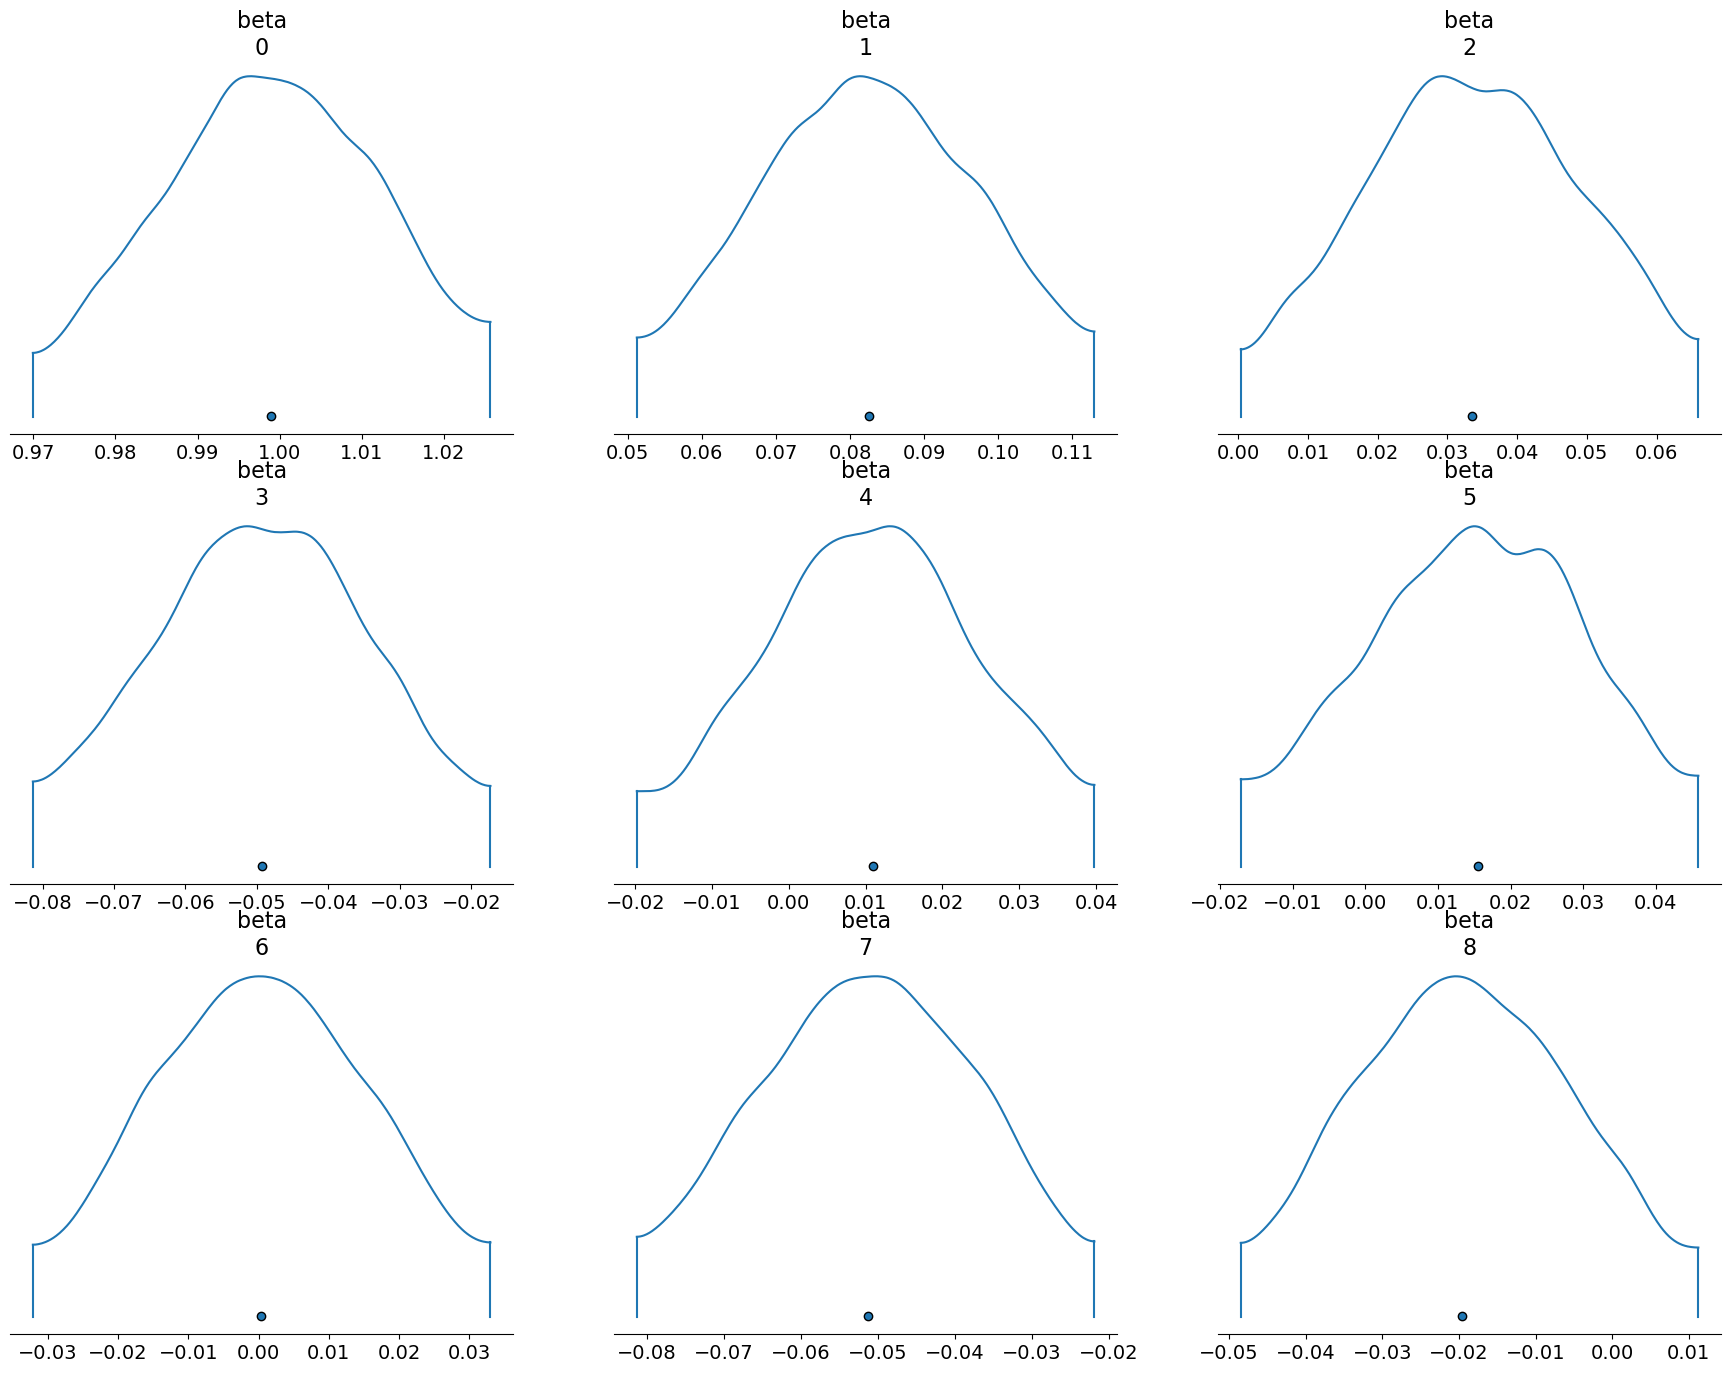

In [112]:
az.plot_density(idata, var_names=["beta"])

# Part 2

In [113]:
from scipy.optimize import minimize # We need to maximize, multiply by -1

def log_posterior(beta, X, y, alpha=alpha):
    return - (y @ (X @ beta) - np.sum(np.exp(X @ beta)) - (.5 / alpha) * np.sum(beta**2))

def grad(beta, X, y, alpha=alpha):
    return - (X.T @ y - X.T @ np.exp(X @ beta) - 1 / alpha * beta)

def hessian(beta, X, y, alpha=alpha):
    return X.T @ (np.diag(np.exp(X @ beta))) @ X + (1 / alpha) * np.eye(X.shape[1])


beta_init = np.zeros(X.shape[1])
result = minimize(
    fun=log_posterior,
    x0=beta_init,
    args=(X, y, alpha),
    method='Newton-CG',
    jac=grad,
    hess=hessian
)

In [114]:
mean_beta = result.x
mean_beta   # We got mu, need standard deviation for each beta

array([ 9.99978598e-01,  8.25836696e-02,  3.38643881e-02, -4.91814280e-02,
        1.10115473e-02,  1.51989728e-02,  2.77957088e-04, -5.16711829e-02,
       -1.92648329e-02])

f(w) = f(z) + (w - z).T * grad(f(z)) + 0.5 * (w - z).T * hessian(f(z)) * (w - z)

In [115]:
# Laplace approximation
hess = hessian(mean_beta, X, y, alpha)
S = np.linalg.inv(hess)  # Covariance matrix

In [116]:
betas_final = []
# mean_beta = mean_beta[1:]  # Exclude intercept  -- dont, you need it later
for i, mbeta in enumerate(mean_beta):
    if i == 0:
        continue
    print(S[i, i])
    sd = np.sqrt(S[i, i])
    
    x_range = 4 * sd    # Range for plotting - get all values within 5 standard deviations - 4 for visualization
    x_val = np.linspace(mbeta - x_range, mbeta + x_range, 100)
    pdf = (1 / (sd * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_val - mbeta) / sd) ** 2)  # Normal pdf
    
    betas_final.append((x_val, pdf))

0.00028136941307898357
0.0003193983627531839
0.00029000063768834744
0.00026117271906344187
0.0002893294200028059
0.0002992167007498516
0.00025536223418979904
0.00025839097361906005


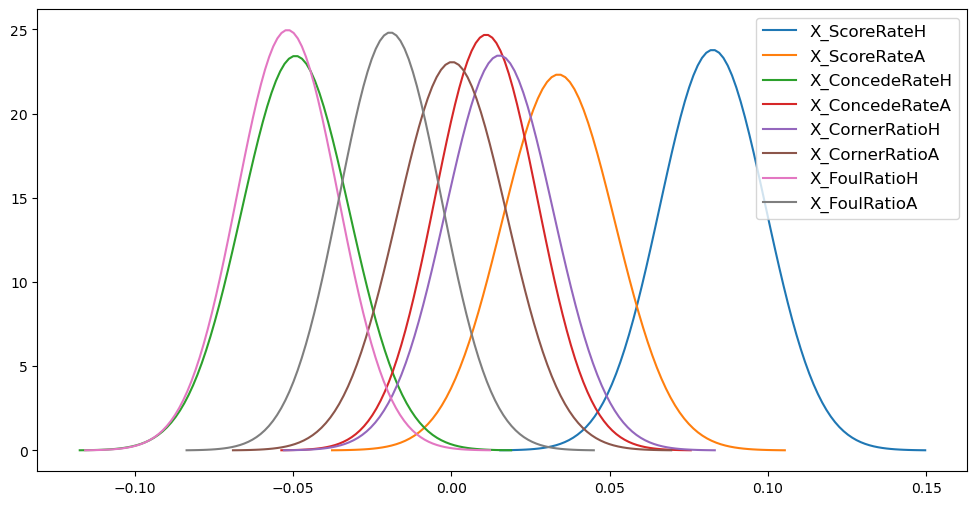

In [118]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, (x_val, pdf) in enumerate(betas_final):
    plt.plot(x_val, pdf, label=f"{names[i]}")
plt.legend(fontsize=12)

In [147]:
idata.posterior["beta"][:, :, 0].values.flatten()  # Intercept values from MCMC samples

array([1.0079208 , 0.9947282 , 1.00540355, ..., 1.01474146, 0.99099041,
       0.97444591], shape=(5000,))

X_ScoreRateA: KDE area = 1.0000
X_ConcedeRateH: KDE area = 1.0000
X_ConcedeRateA: KDE area = 1.0000
X_CornerRatioH: KDE area = 1.0000
X_CornerRatioA: KDE area = 1.0000
X_FoulRatioH: KDE area = 1.0000
X_FoulRatioA: KDE area = 1.0000
GoalsScored: KDE area = 1.0000


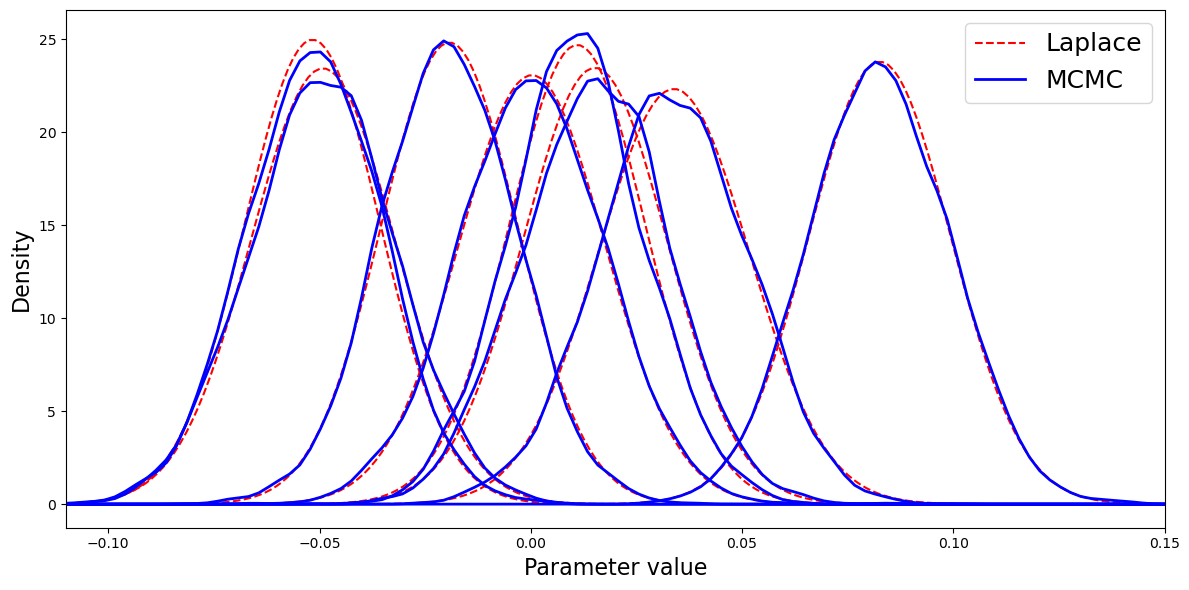

In [ ]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson as simps

plt.figure(figsize=(12, 6))

all_samples = [idata.posterior['beta'][:, :, i].values.flatten() for i in range(len(names)-1)]
flat_all = np.concatenate(all_samples)
x_vals = np.linspace(flat_all.min() - 0.02, flat_all.max() + 0.02, 500)

for i, (x_val, pdf) in enumerate(betas_final):
    if i == 0:
        plt.plot(x_val, pdf, label="Laplace", linestyle='--', c='r')
    else:
        plt.plot(x_val, pdf, linestyle='--', c='r')

for i, name in enumerate(names):
    if i == 0:  # Skip intercept
        continue
    samples = idata.posterior['beta'][:, :, i].values.flatten()
    kde = gaussian_kde(samples)
    area = simps(kde(x_vals), x_vals)
    print(f"{name}: KDE area = {area:.4f}") # Correct area
    if i == 1:
        plt.plot(x_vals, kde(x_vals), label=f"MCMC", linewidth=2, c="b")
    else:
        plt.plot(x_vals, kde(x_vals), linewidth=2, c="b")
        
plt.xlim(-0.11, 0.15)
plt.legend(fontsize=18)
plt.xlabel("Parameter value", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.tight_layout()
plt.show()


### Test predictions

In [119]:
# Prepare data
X_test = scaler.fit_transform(test.drop(columns=["GoalsScored"]))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))  # intercept

In [120]:
beta_samples = np.random.multivariate_normal(mean_beta, S, size=1000)
pred_samples = np.exp(X_test @ beta_samples.T)  # Predictions for each sample

# point estimates
# MSE
mse_pred = np.mean(pred_samples, axis=1)

# Abs error
abs_pred = np.median(pred_samples, axis=1)

# Accuracy
from scipy.stats import mode
acc_pred = np.round(mode(pred_samples, axis=1).mode.flatten()).astype(int)

In [121]:
mse_pred, abs_pred, acc_pred

(array([2.68889763, 2.59510908, 2.41460702, 2.95169254, 2.66900319,
        3.52649333, 2.35925446, 2.55045678, 2.61061876, 2.76315661,
        3.99980336, 2.4629188 , 3.00665097, 2.53086482, 2.20685257,
        2.59045415, 2.59055673, 2.52874183, 2.77634332, 2.43310762,
        2.10206583, 3.08287678, 2.53550593, 2.26728462, 2.61860835,
        3.86522667, 4.32680047, 3.14678782, 2.91787444, 2.55272042,
        2.57509465, 2.70592616, 3.86288898, 2.49269423, 3.00266415,
        2.33687765, 3.27317579, 2.40175668, 2.47436366, 2.57297852,
        2.74756081, 2.76853468, 2.58893565, 2.61673876, 4.2282362 ,
        2.69504293, 2.42836297, 2.41916753, 2.43191866, 2.40390987,
        2.19768483, 2.41800539, 2.66889775, 3.31211658, 2.67269277,
        2.97910935, 2.84211149, 3.05688649, 2.81671773, 2.87541124,
        2.44430353, 1.95340618, 2.52827806, 2.79353806, 2.91279759,
        2.50537824, 2.35855357, 2.2014069 , 2.33061195, 2.42499287,
        2.73383573, 2.49800449, 3.7710311 , 2.20

In [122]:
len([i for i in acc_pred if i == 2])


72

(array([72.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 26.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2,
        3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. ]),
 <BarContainer object of 20 artists>)

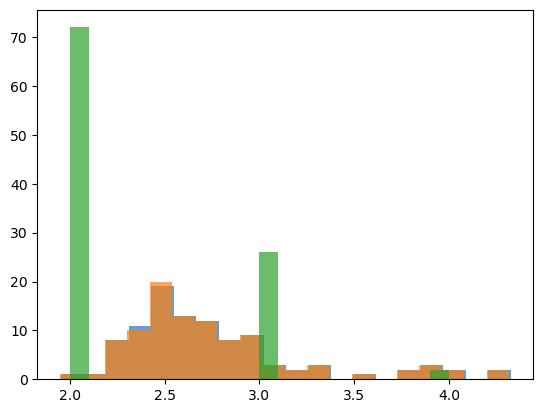

In [123]:
fig, ax1 = plt.subplots()

# Plot histograms on primary y-axis
ax1.hist(mse_pred, bins=20, alpha=0.7, label='mse_pred')
ax1.hist(abs_pred, bins=20, alpha=0.7, label='abs_pred')
ax1.hist(acc_pred, bins=20, alpha=0.7, label='acc_pred')

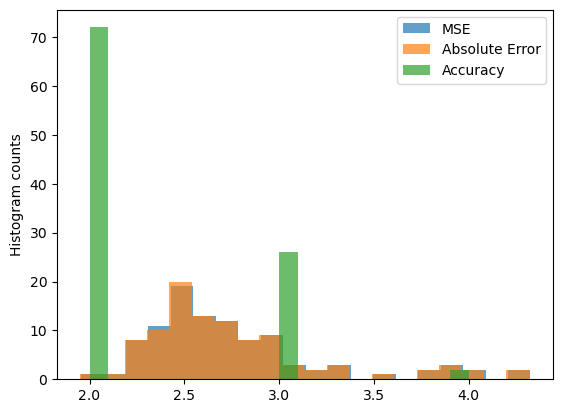

In [124]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# Plot histograms on primary y-axis
ax1.hist(mse_pred, bins=20, alpha=0.7, label='MSE')
ax1.hist(abs_pred, bins=20, alpha=0.7, label='Absolute Error')
ax1.hist(acc_pred, bins=20, alpha=0.7, label='Accuracy')
ax1.set_ylabel('Histogram counts')
ax1.legend(loc='upper right')

ppc_vals = idata.posterior_predictive.y_obs.values.flatten()

plt.show()
